# ¿Existe una relación léxica entre dos o más clústeres que hablan sobre distintos sectores?


Se cuentan con los dataframes df, que contiene las noticias, y el dataframe clusters, que contiene información de los clusters de noticias.

- **columnas df**: ['id_news', 'country', 'media_outlet', 'url', 'title', 'text', 'date', 'cities', 'keywords', 'Document', 'Topic', 'Probability']
 
- **columnas clusters**: ['Topic', 'Count', 'Representation']

In [1]:
import re
import sys
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

sys.path.append('scripts/')

from utils import get_representative_description
from utils import create_graph
from utils import sort_nodes_by_degree_centrality
from utils import determine_edge_weights
from utils import visualize_graph

# Configuración de opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 255)

# Lectura del archivo CSV de noticias
df = pd.read_csv("data/noticias-etiquetadas2.csv")
df.drop(columns=["Unnamed: 0", "text", "media_outlet", "url", "cities", "Probability", "date", "country", "Document"], inplace=True)
df.drop(df[df['Topic'] == -1].index, inplace=True)

def clean_title(title):
    split_title = title.split('-')[0]
    return split_title

df["title"] = df["title"].apply(clean_title)
df.drop_duplicates(subset=['title'], inplace=True)

# Imprimir el número de noticias en los meses Enero y Febrero de 2022
print("Número de noticias en los meses Enero y Febrero de 2022:", len(df))
df.head(2)

Número de noticias en los meses Enero y Febrero de 2022: 1327


,id_news,title,keywords,Topic
1,47719086.0,Tractocamión volcó esta mañana en puente Llollelhue por la ruta 5 Sur,"['puente', 'victimas', 'bomberos', 'semi remolque', 'alimento']",0
2,47719110.0,Gobernadores Regionales de Los Ríos y Los Lagos participaron de Encuentro Birregional en Río Bueno,"['gobernadores', 'ambas regiones', 'puyehue', 'turismo', 'biosfera']",15


In [2]:
# Lectura del archivo CSV de clusters
clusters = pd.read_csv("data/clusters2.csv")
clusters.drop(columns=["Unnamed: 0", "Name", "Representative_Docs"], inplace=True)
clusters.drop(clusters[clusters['Topic'] == -1].index, inplace=True)

clusters["Representation"] = clusters.Representation.apply(get_representative_description)
clusters

,Topic,Count,Representation
1,0,155,Accidentes en ruta en Chile
2,1,73,Proyecto de vivienda en Chile
3,2,72,Incendio en la Región Metropolitana
4,3,68,Crisis de niebla en Valparaíso
5,4,63,Teatro en Chile
6,5,47,Drogas en Chile
7,6,40,Desafíos de la gestión de obras públicas
8,7,39,Comercio y acción empresarial en Chile
9,8,36,Desafíos de la Educación
10,9,36,Tormentas electricas en Chile


<a>

## 1. Análisis de noticias en cluster mediante conexiones a través de sus keywords


Para este análisis se selecciona uno de los 71 clusteres.

Para este análisis nos concentraremos en un cluster específico: N°21 - "Financiamiento Municipal en Chile".
Este cluster presenta las noticias que se muestran a continuación.

En las siguientes celdas de código se construirá un grafo:
- Nodos: Los nodos son las noticias del cluster representadas por su id.
- Aristas: Son las keywords que las noticias tienen en común.

Puesto que son noticias de un mismo cluster, se espera obtener sectores del cluster que tratan el mismo hecho causal y otros que tratan hechos aledaños. 
    
</a>

In [3]:
df.loc[df.Topic == 21][['id_news','title','keywords']]

,id_news,title,keywords
73,47689514.0,En Panguipulli invertirán $ 615 millones en obras de pavimentación participativa,"['urbanismo proyecto', 'millones', 'jazmines lago pellaifa', 'calidad', 'inversion']"
161,47690074.0,"Anuncian pavimentación de 12,5 kilómetros de calles, pasajes y veredas de Los Ríos","['rios ignacio', 'urbanismo', 'pesos', 'mil millones', 'inversion']"
166,47690597.0,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia","['municipalidades', 'chilecompras servicio', 'hotel', 'impuestos', 'carampangue']"
197,47688574.0,Cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua,"['aguas', 'plan piloto', 'municipalidad', 'deficit', 'reunion']"
262,47719148.0,La Unión: alcalde y dirigentas sostienen reunión con ministra de Transportes y Telecomunicaciones por barcaza de Llancacura,"['alcaldes', 'santiago', 'viajes', 'reunion', 'telecomunicaciones']"
347,47687106.0,Valdivia: autoridades y funcionarios municipales de todo el país se reunirán para abordar el escenario de las Finanzas Municipales,"['municipalidades', 'presupuesto', 'chilecompras servicio', 'hotel', 'carampangue']"
401,47732395.0,"Corporación Municipal anuncia auditoría interna para evaluar gestión administrativa, financiera y contable","['administracion', 'presupuestarios', 'transparencia', 'seis meses', 'reunion']"
405,47732402.0,En Panguipulli invertirán $ 615 millones en obras de pavimentación participativa,"['urbanismo proyecto', 'pesos', 'millones', 'jazmines lago pellaifa', 'inversion']"
653,47767819.0,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia para abordar el complejo escenario de las Finanzas Municipales","['municipalidades', 'chilecompras servicio', 'presupuesto', 'hotel', 'carampangue']"
661,47771423.0,Gobernador Díaz se reunió con representantes del sector productivo de Contulmo,"['gobernador', 'sector', 'reunion', 'vivienda', 'biobio']"


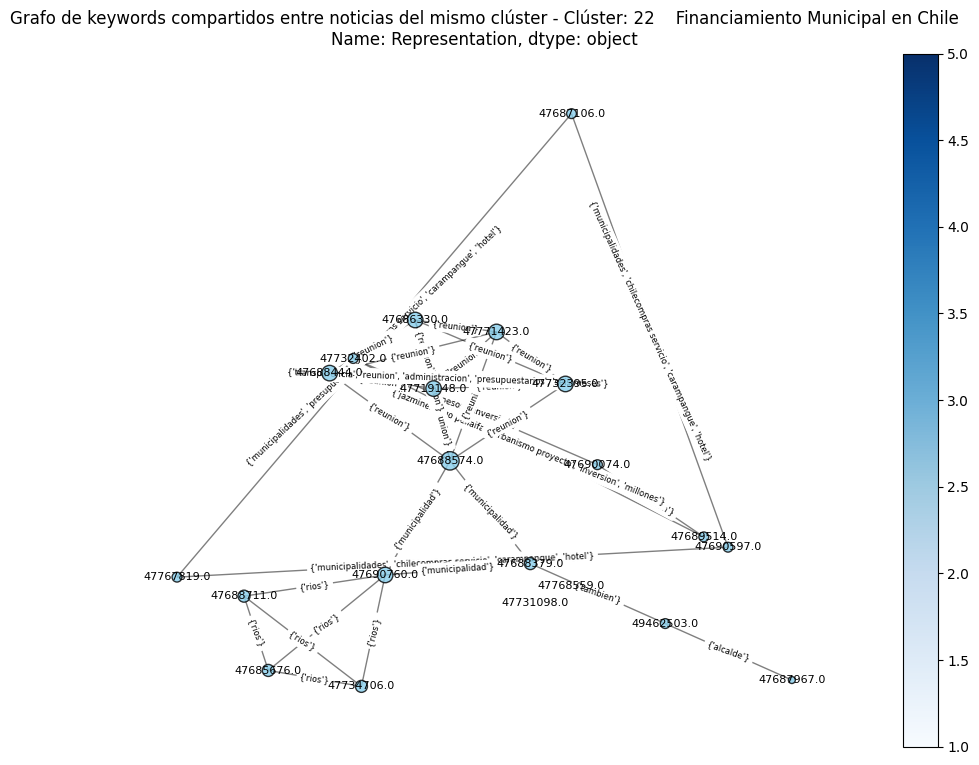

In [4]:
from utils import shared_keywords_of_news_in_cluster

graph = shared_keywords_of_news_in_cluster(df, clusters, cluster_num=21)
graph

<a>

El grafo obtenido muestra resultados interesantes:
1. Los conectores que vinculan más noticias son "reunión" y "rios".
2. Existen 3 noticias que presentan relaciones en más de un keyword. Se infiere que pueden ser noticias duplicadas.
    
</a>

In [5]:
# Noticias conectadas con más de tres keywords
ids = [47767819.0, 47690597.0, 47687106.0]
df.loc[df['id_news'].isin(ids)]

,id_news,title,keywords,Topic
166,47690597.0,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia","['municipalidades', 'chilecompras servicio', 'hotel', 'impuestos', 'carampangue']",21
347,47687106.0,Valdivia: autoridades y funcionarios municipales de todo el país se reunirán para abordar el escenario de las Finanzas Municipales,"['municipalidades', 'presupuesto', 'chilecompras servicio', 'hotel', 'carampangue']",21
653,47767819.0,"Alcaldes, concejales y funcionarios municipales de todo el país se reunirán en Valdivia para abordar el complejo escenario de las Finanzas Municipales","['municipalidades', 'chilecompras servicio', 'presupuesto', 'hotel', 'carampangue']",21


## 1.1 Centralidad: Qué estructura se forma?

Sorted Nodes: [47688574.0, 47719148.0, 47732395.0, 47771423.0, 47688444.0, 47690760.0, 47686330.0, 47688379.0, 47688711.0, 47685676.0, 47734706.0, 47689514.0, 47690074.0, 47690597.0, 47687106.0, 47732402.0, 47767819.0, 49462503.0, 47687967.0, 47731098.0, 47768559.0]
                                                                                                                           title
197                                            Cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua 
262  La Unión: alcalde y dirigentas sostienen reunión con ministra de Transportes y Telecomunicaciones por barcaza de Llancacura
401                   Corporación Municipal anuncia auditoría interna para evaluar gestión administrativa, financiera y contable
661                                               Gobernador Díaz se reunió con representantes del sector productivo de Contulmo
884                                Cormupa anuncia auditoría interna para evaluar gestió

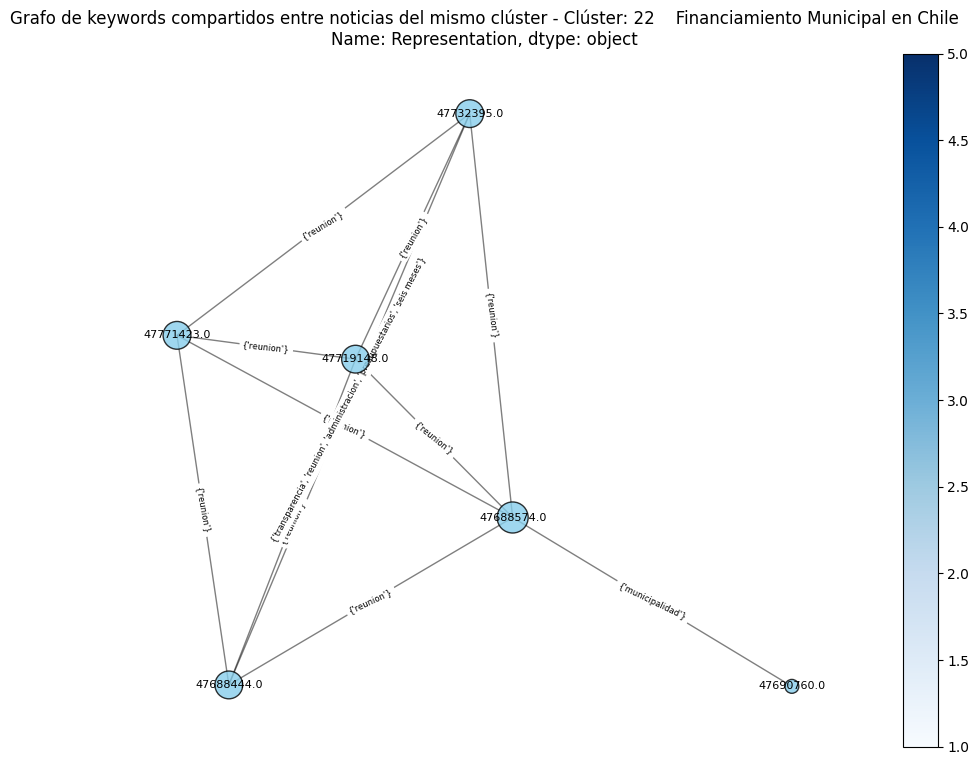

In [6]:
graph = create_graph(df[df['Topic'] == 21])

# Ordenar nodos por grado de centralidad
sorted_nodes = sort_nodes_by_degree_centrality(graph)
print("Sorted Nodes:", sorted_nodes)
print(df.loc[df['id_news'].isin(sorted_nodes[:6])][["title"]])

ids = sorted_nodes[:6]
filtered_rows = df[df['id_news'].isin(ids)]
graph2 = create_graph(filtered_rows)
determine_edge_weights(graph2)
visualize_graph(graph2, filtered_rows, clusters, 21)

## 1.3 Comunidades: Algoritmo de Louvain
La función community_louvain implementa el algoritmo de Louvain para realizar la partición de un grafo en comunidades. A diferencia de otros algoritmos que buscan una partición óptima global, el algoritmo de Louvain utiliza un enfoque heurístico basado en la optimización local. A continuación, se explican los pasos principales del algoritmo:

1. Inicialización: En la primera etapa, cada nodo del grafo se asigna a una comunidad diferente, es decir, cada nodo se considera como una comunidad independiente.

2. Bucle de optimización: El algoritmo itera entre dos pasos hasta que no se pueda mejorar la modularidad global del grafo:

    2.1. Paso 1: Movimiento de nodos entre comunidades: En este paso, se selecciona cada nodo en el grafo y se evalúa el beneficio de moverlo a una comunidad vecina. Se calcula el cambio en la modularidad si el nodo se mueve a cada una de las comunidades vecinas y se selecciona la comunidad que maximice el cambio en la modularidad. El nodo se mueve a la comunidad seleccionada.

    2.2 Paso 2: Contracción de comunidades: En este paso, se contraen las comunidades en un solo nodo para formar un nuevo grafo, donde los nodos del nuevo grafo representan las comunidades del grafo original. Se calculan las conexiones ponderadas entre las comunidades y se reemplazan por una sola conexión ponderada. El proceso de contracción de comunidades se repite hasta que no se pueda mejorar la modularidad global.

3. Resultado final: Una vez que no se puede mejorar la modularidad global, se obtiene la partición final del grafo, donde los nodos están agrupados en comunidades.

Al aplicar el algoritmo de Louvain y utilizar la función para visualizar el grafo con la partición coloreada, podemos obtener las siguientes utilidades:

- Identificación de comunidades: El algoritmo de Louvain asigna un identificador de comunidad a cada nodo del grafo, lo que nos permite identificar y etiquetar los diferentes grupos o comunidades presentes en el grafo. Esto es útil para comprender la estructura y la organización de los nodos dentro del grafo.

- Análisis de la modularidad: La modularidad es una medida que evalúa qué tan bien se agrupan los nodos en comunidades. Al calcular la modularidad de la partición obtenida, podemos obtener una medida numérica de la calidad de la estructura de las comunidades en el grafo. Una mayor modularidad indica una mejor agrupación de los nodos en comunidades.

- Visualización de comunidades: La función también proporciona una representación visual del grafo con la partición coloreada. Los nodos que pertenecen a la misma comunidad se representan con el mismo color, lo que facilita la identificación visual de las comunidades y cómo se relacionan entre sí.

/home/ricki/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


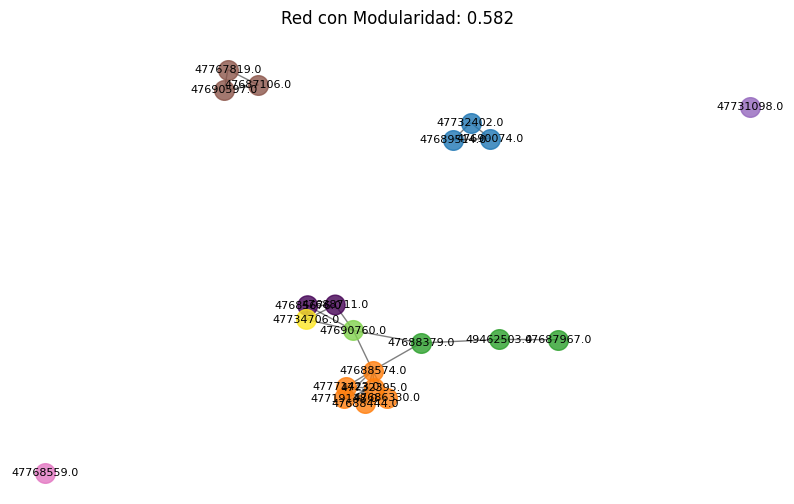

In [7]:
from utils import community_louvain

graph = create_graph(df[df['Topic'] == 21])
partition_dict = community_louvain(graph)

In [8]:
community_sorted = dict(sorted(partition_dict.items(), key=lambda x: x[1]))
community_sorted

{47689514.0: 0,
 47690074.0: 0,
 47732402.0: 0,
 47688574.0: 1,
 47719148.0: 1,
 47732395.0: 1,
 47771423.0: 1,
 47688444.0: 1,
 47686330.0: 1,
 47688379.0: 2,
 47687967.0: 2,
 49462503.0: 2,
 47690760.0: 3,
 47688711.0: 3,
 47685676.0: 3,
 47734706.0: 3,
 47731098.0: 4,
 47690597.0: 5,
 47687106.0: 5,
 47767819.0: 5,
 47768559.0: 6}

In [9]:
# Obtener noticias por comunidad 
df.loc[df['id_news'].isin([key for key, value in community_sorted.items() if value == 1])] # Change value to inspect other communities

,id_news,title,keywords,Topic
197,47688574.0,Cehum y municipio laguino proyectan generar plan piloto para el cuidado del agua,"['aguas', 'plan piloto', 'municipalidad', 'deficit', 'reunion']",21
262,47719148.0,La Unión: alcalde y dirigentas sostienen reunión con ministra de Transportes y Telecomunicaciones por barcaza de Llancacura,"['alcaldes', 'santiago', 'viajes', 'reunion', 'telecomunicaciones']",21
401,47732395.0,"Corporación Municipal anuncia auditoría interna para evaluar gestión administrativa, financiera y contable","['administracion', 'presupuestarios', 'transparencia', 'seis meses', 'reunion']",21
661,47771423.0,Gobernador Díaz se reunió con representantes del sector productivo de Contulmo,"['gobernador', 'sector', 'reunion', 'vivienda', 'biobio']",21
884,47688444.0,"Cormupa anuncia auditoría interna para evaluar gestión administrativa, financiera y contable","['administracion', 'presupuestarios', 'transparencia', 'seis meses', 'reunion']",21
1987,47686330.0,Municipio de Valdivia fue el primero del país en sostener una reunión con el presidente electo Gabriel Boric,"['alcaldesa', 'reunion', 'tenor', 'conectividad', 'cargo']",21


## 2. Análisis de sectores y sus clusters considerando las keywords de sus noticias

#### Agrupación de clusters en sectores de interés

- Grupo 1: Salud
[0, 3, 5, 12, 17, 24, 25, 26, 31, 35, 43, 52, 54, 55]

- Grupo 2: Economía y Negocios
[1, 6, 7, 8, 11, 18, 21, 22, 28, 49, 50, 61]

- Grupo 3: Medio Ambiente
[2, 10, 15, 9, 19, 20, 34, 62, 63, 64]

- Grupo 4: Educación
[4, 8, 16]

- Grupo 5: Otros
[14, 13, 23, 30, 27, 29, 32, 33, 36, 46, 47, 48, 56, 57, 58, 60, 65, 66, 67]

In [10]:
from utils import extract_keywords

# Crear una función para combinar listas sin duplicados
def combine_lists(list_of_lists):
    combined_list = list(set([item for sublist in list_of_lists for item in sublist]))
    return combined_list

# Crear una lista de listas de keywords por cluster
keywords_by_cluster = []
for cluster_num in clusters['Topic']:
    list_of_lists = []
    for elem in df.loc[df.Topic == cluster_num, 'keywords'].tolist():
        list_of_lists.append(extract_keywords(elem))
    combined_list = combine_lists(list_of_lists)
    keywords_by_cluster.append(combined_list)

# Agregar la columna 'keywords' al DataFrame clusters
clusters['keywords'] = keywords_by_cluster

In [11]:
salud = [0, 3, 12, 17, 24, 25, 26, 31, 35, 43, 52, 54, 55, 64]
economia = [1, 6, 7, 8, 11, 18, 21, 22, 28, 49, 50, 61]
medio_ambiente = [2, 10, 15, 9, 19, 20, 34, 62, 63]
educacion = [4, 8, 16]

clusters_salud = clusters[clusters['Topic'].isin(salud)]
clusters_economia = clusters[clusters['Topic'].isin(economia)]
clusters_medio_ambiente = clusters[clusters['Topic'].isin(medio_ambiente)]
clusters_educacion = clusters[clusters['Topic'].isin(educacion)]

sectores = [clusters_salud, clusters_economia, clusters_medio_ambiente, clusters_educacion]    

In [12]:
clusters_medio_ambiente

,Topic,Count,Representation,keywords
3,2,72,Incendio en la Región Metropolitana,"[kilometros, bomberos evito, helicoptero, cargo, estado, templo, gas, maquinaria, asfalto, brigada arauco, vecinos, plantacion, voluntarios, congestion, vivienda, incendio, nontuela, jardin, lugar, corral, once personas, matorrales, camioneta, peligro..."
10,9,36,Tormentas electricas en Chile,"[causas, metal alambrados, precipitaciones, nudos, verano, tarde, tambien, estado, comunas cordilleranas, delegado, semana, normalidad, medida, decision asi tambien, pronosticos, peso, domingo, alerta, cianobacterias, actualizacion, rutas, lago ranco,..."
11,10,35,Incendios forestales en Chile,"[probabilidad, conductas preventivas, tormenta, cuatro incendios, calendario, helicoptero, autoridad, eucaliptos tres hectareas, bomberos, viviendas, extincion, balance incendios, incendios, luma ambos pertenecientes, contratistas, taico, vecinos, pre..."
16,15,29,Riesgos y desafíos de agua potable en Chile,"[monumentos, usuarios, proyecto reposicion estadio, resultados, memoria, vecinos, presidente, aumentos, agricultoras, escuela, directiva, agua, alcalde, camion, emergencia, deuda, core, proyecto, heladas, red, propuestas, presupuestos, tambien, infrae..."
20,19,28,Desaparición de dos niños en la comuna de Union,"[dos ninas, beatriz, condena, hemoperitineo, union, amenazas, feminista, fiscal, presidio, imputado, cargo, abstracto, sentenciado, muerte, rio, diez anos, imparcialidad, nueve pacientes mujeres, medida, peso, calidad, apelaciones, tres camionetas, mu..."
21,20,26,La política municipal de transporte en Valparaíso,"[patentes, medida calle, toldos, jueves, aves mamiferos, ciclistas, celebracion, agresiones, colegio, tweets, alerces, mil vehiculos, monitores, municipio, alcalde, costanera, paillaco, botellas, calle, funcionaria, tambien, seguridad publica, calidad..."
35,34,19,El servicio de la electricidad en Chile,"[interrupciones, colaboradores, maihue, plan, localidades futroninas, clientes pablo, conductores, cable, bomberos, precaucion, media tension, usuarios, lineas, familias, arboles, asfalto, cuatro postes, trabajo remoto, vecinos, suministro, arteria, f..."
63,62,11,Desigualdad e inseguridad ambiental en Chile,"[reserva, termitas, inspeccion, pandemia, tambien, ademas, glaciar, cauce, ecosistemas, tribunal, agroquimicos, ministra, vivienda, urbanismo serviu, mocho choshuenco, rios, miles, tribunal rechazo dos cautelares, inactividad, villalobos, abejas pecor..."
64,63,11,Incendio en Rio Bueno,"[tristeza, causas, romeria bomberos, fuego, puente, bomberos, saldo dos viviendas, saldo cuatro familias, rio, voluntarios, vivienda, medina, incendio, cooperacion, funeral, dormia, cementerio, rios, cuatro viviendas, murillo rescato, horas, joven, fa..."


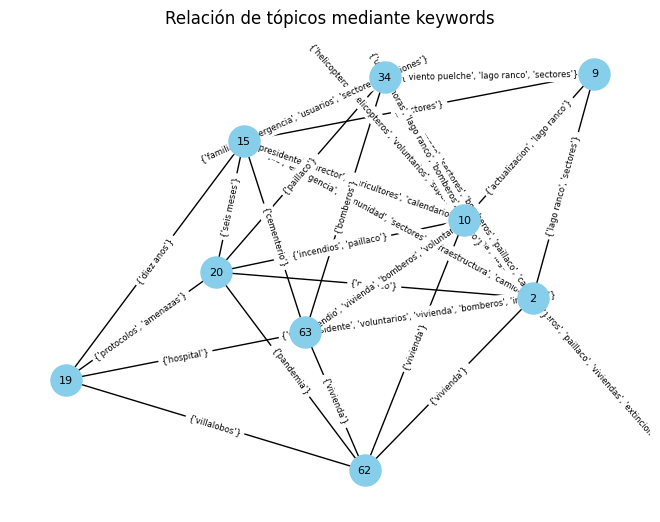

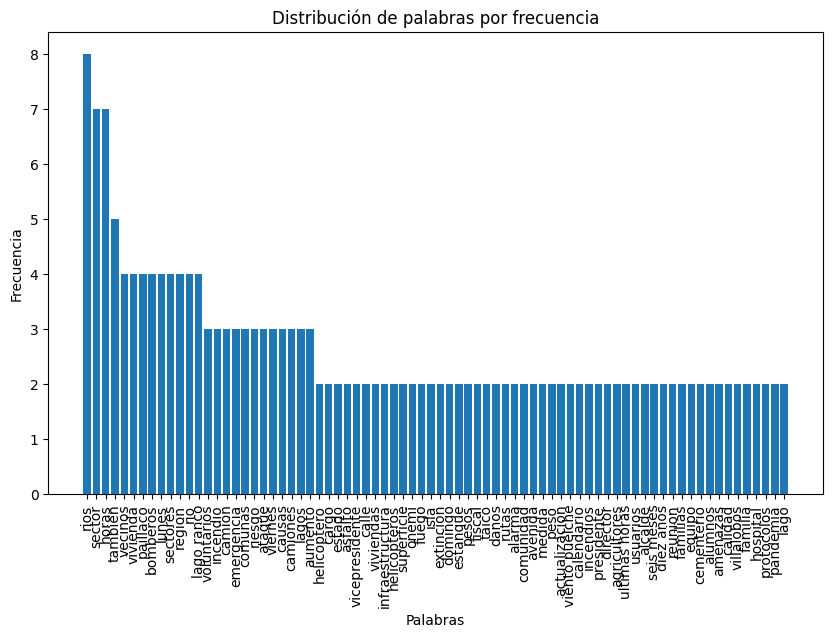

In [13]:
from utils import keyword_distribution
from utils import generate_graph_from_dataframe

generate_graph_from_dataframe(clusters_medio_ambiente)  # Llamar a la función para generar el gráfico
keyword_distribution(clusters_medio_ambiente)  # Llamar a la función para generar el gráfico

## 3. Análisis de sector vs sector (medioambiente vs economia)


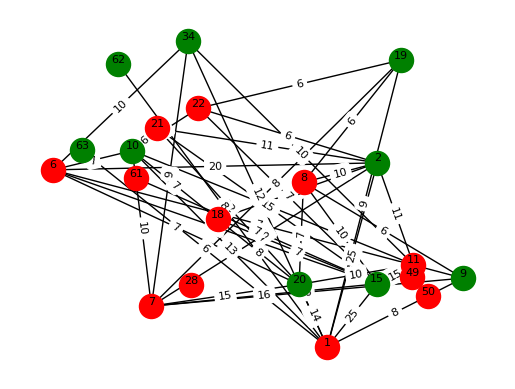

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

# Crear un nuevo grafo
grafo = nx.Graph()

# Agregar nodos del dataframe clusters_medio_ambiente (verdes)
for i, fila in clusters_medio_ambiente.iterrows():
    topic_id = fila['Topic']
    keywords = fila['keywords']
    grafo.add_node(topic_id, color='green', keywords=keywords)

# Agregar nodos del dataframe clusters_economia (rojos)
for i, fila in clusters_economia.iterrows():
    topic_id = fila['Topic']
    keywords = fila['keywords']
    grafo.add_node(topic_id, color='red', keywords=keywords)

# Agregar aristas entre nodos según las condiciones
for nodo1, attr1 in grafo.nodes(data=True):
    color1 = attr1['color']
    keywords1 = attr1['keywords']
    
    for nodo2, attr2 in grafo.nodes(data=True):
        color2 = attr2['color']
        keywords2 = attr2['keywords']
        
        if color1 != color2:
            common_keywords = [keyword for keyword in keywords1 if keyword in keywords2]
            num_common_keywords = len(common_keywords)
            if num_common_keywords > 5:
                grafo.add_edge(nodo1, nodo2, num_relations=num_common_keywords, keywords=common_keywords)

# Obtener colores y keywords de los nodos
colores_nodos = [attr['color'] for _, attr in grafo.nodes(data=True)]
keywords_nodos = [attr['keywords'] for _, attr in grafo.nodes(data=True)]

# Dibujar los nodos con colores diferentes y etiquetas de IDs de temas
nodos_verdes = [nodo for nodo, attr in grafo.nodes(data=True) if attr['color'] == 'green']
nodos_rojos = [nodo for nodo, attr in grafo.nodes(data=True) if attr['color'] == 'red']

posiciones = nx.random_layout(grafo)
nx.draw_networkx_nodes(grafo, pos=posiciones, nodelist=nodos_verdes, node_color='green')
nx.draw_networkx_nodes(grafo, pos=posiciones, nodelist=nodos_rojos, node_color='red')

# Dibujar las aristas con etiquetas de número de relaciones
edge_labels = nx.get_edge_attributes(grafo, 'num_relations')
nx.draw_networkx_edges(grafo, pos=posiciones)
nx.draw_networkx_edge_labels(grafo, pos=posiciones, edge_labels=edge_labels, font_size=8)

# Agregar etiquetas a los nodos con los IDs de temas
etiquetas = {nodo: str(nodo) for nodo in grafo.nodes}
nx.draw_networkx_labels(grafo, pos=posiciones, labels=etiquetas, font_size=8, verticalalignment='bottom')

# Mostrar el grafo
plt.axis('off')
plt.show()


In [15]:
# Obtener las aristas y ordenarlas por el número de relaciones en orden decreciente
edges_sorted = sorted(grafo.edges(data=True), key=lambda x: x[2]['num_relations'], reverse=True)

# Imprimir las aristas con los números más altos en el formato "nodoA-nodoB-N"
for edge in edges_sorted:
    nodoA, nodoB, num_relations, keywords = edge[0], edge[1], edge[2]['num_relations'], edge[2]['keywords']
    print(f"{nodoA}-{nodoB}-{num_relations}")
    print(keywords)

2-1-25
['cargo', 'vecinos', 'vivienda', 'corral', 'emergencia', 'ranco', 'infraestructura', 'supermercado', 'cereales', 'rios', 'lunes', 'superficie', 'onemi', 'sector', 'almacenamiento', 'isla', 'viernes', 'pesos', 'horas', 'region', 'lagos futrono', 'fiscal', 'futrono', 'comunidad', 'lagos']
15-1-25
['vecinos', 'presidente', 'agua', 'alcalde', 'emergencia', 'deuda', 'proyecto', 'presupuestos', 'infraestructura', 'rios', 'humedales', 'regiones', 'sector', 'millones', 'isla', 'reunion', 'viernes', 'region', 'olores', 'familias', 'incremento', 'semanas', 'comunidad', 'presidenta', 'alcantarillado']
2-6-20
['cargo', 'asfalto', 'vecinos', 'congestion', 'peligro', 'emergencia', 'retroexcavadora', 'tambien', 'supermercado', 'comunas', 'rios', 'lunes', 'onemi', 'sector', 'isla', 'sectores', 'pesos', 'esquina', 'danos', 'rutas']
15-6-16
['vecinos', 'presidente', 'agua', 'alcalde', 'emergencia', 'deuda', 'core', 'tambien', 'comunas', 'rios', 'sector', 'isla', 'reunion', 'sectores', 'familias',

In [16]:
pd.set_option('display.max_colwidth', None)
relation = [15,6]

cluster_rel=clusters.loc[clusters['Topic'].isin(relation)]
cluster_rel

,Topic,Count,Representation,keywords
7,6,40,Desafíos de la gestión de obras públicas,"[gobierno, cargo, consejo insultos actitudes, insultos, comision, asfalto, buses, vecinos, presidente, congestion, trabajos, bus, ciudad autoridades, tuberia, ejercicio, peligro, mil vehiculos, organismos, agua, rapidez, temor ademas, alcalde, emergencia, deuda, retroexcavadora, sentencia, satelites starlink, core, cambios, matriz, justificado temor, semaforos, marcela, coordinacion, tambien, ademas, preocupacion, supermercado, quinientas, comunas, cau, elecciones, rios, ambas comunas, cuatro horas, lunes, periodo, nibaldo villegas, irresponsabilidad, transportes, luces, autoridades, onemi, paralizacion, sector, autoridad, isla, manifestantes, ruta pellinadalas, kilos, congestiones, comision concluyo, reunion, arteria, infracciones, conexion, emprendedores, flota, tren, piscina, sectores, estacionamientos, pesos, lago pellaifa, wwwmunivaldiviacl, esquina, ruta valdivianiebla, lluvias, desestabilizacion, solis, ruta mop entrego detalles, contaminantes, transito, nueve personas, situacion ambos parlamentarios, manifestaciones, estructura, petitorio, familias, ruta, rios gobernador, desarrollo producto, danos, rutas, ministro, amapolas, asfaltado intermedio, agua aislamiento peligro, presupuesto, ruta nieblalos, ...]"
16,15,29,Riesgos y desafíos de agua potable en Chile,"[monumentos, usuarios, proyecto reposicion estadio, resultados, memoria, vecinos, presidente, aumentos, agricultoras, escuela, directiva, agua, alcalde, camion, emergencia, deuda, core, proyecto, heladas, red, propuestas, presupuestos, tambien, infraestructura, municipalidades, comunas, ambas regiones, transito seis mudadores, seis meses, ocho comites, impuesto, organizacion, rios, humedales, regiones, click, materiales, riesgos, hermosilla, fndr, desarrollo, sector, millones, ecologia biodiversidad, horizonte, isla, diez anos, descentralizacion, reunion, turismo, sequia, normas, biosfera, estanque, sectores, viernes, agricultores, educacion servicios, region, ciclo, generador, dos camiones, mil millones, sustentabilidad, expectativas, puyehue, gobernadores, fondos, calendario, paralelo, ampliacion, financiamiento autoridades, rio, videomapping, olores, familias, diputados, valdivia entrega agua, localidades, equipo, incremento, terremoto, minas, proyecto viajes, aumento, cementerio, director, presupuesto, semanas, comunidad, plan piloto, alumnos, rios respecto, presidenta, chaihuin, camiones, gobernador, alcantarillado, inactividad producto]"


In [17]:
r15n6 = df.loc[df['Topic'].isin(relation)]
r15n6[["title","Topic"]]

,title,Topic
2,Gobernadores Regionales de Los Ríos y Los Lagos participaron de Encuentro Birregional en Río Bueno,15
14,USS Valdivia prepara recorrido multisensorial por la Región de Los Ríos,15
26,Paillaco enfrenta escasez hídrica con conformación de Unión Comunal de Agua Potable Rural y de Defensa del Territorio,15
50,Buscan adquirir terreno donde instalar futura planta de alcantarillado para Antilhue,15
53,Comenzaron a regir cambios en sentido del tránsito en calles de Panguipulli,6
84,Cámara hoy resolverá proyecto de Berger en homenaje a “Héroes del Riñihue”,15
122,Marejadas destruyen Muelle de Las Coloradas en Isla del Rey,6
139,Autoridades piden decretar Estado de Emergencia en sector costero de Valdivia,6
157,Tras corte de ruta hasta marzo: cunde la angustia entre vecinos del sector Las Vertientes,6
167,Grieta en ruta Niebla,6


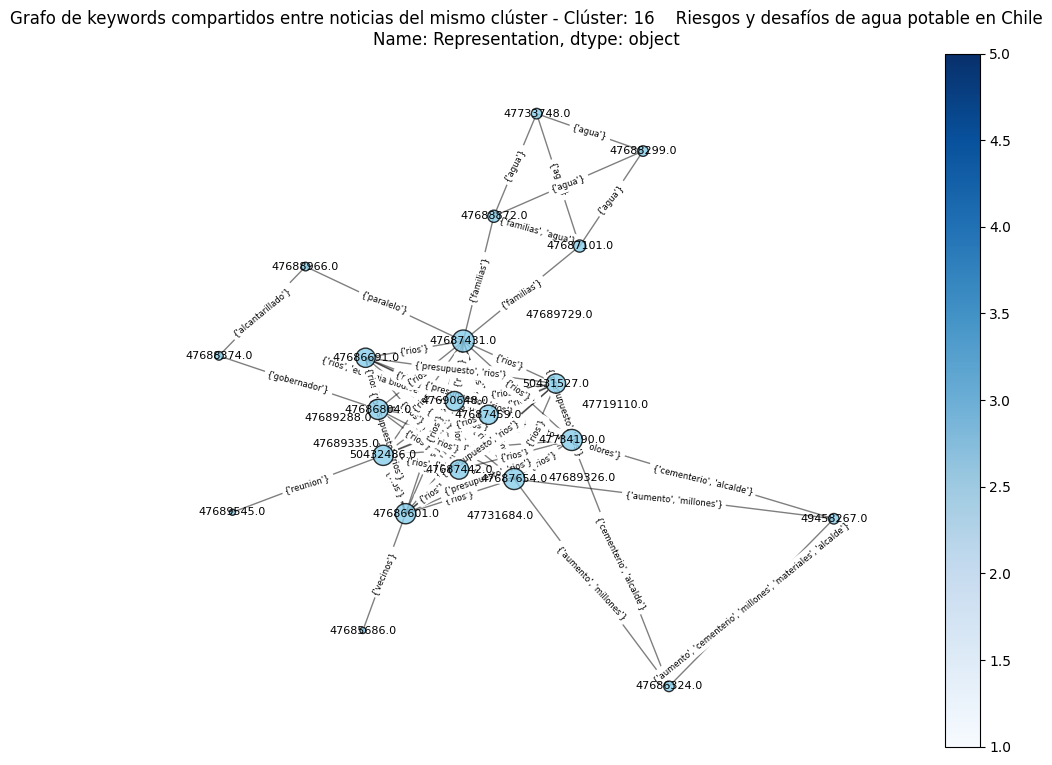

In [18]:
graph=shared_keywords_of_news_in_cluster(r15n6, cluster_rel, 15)
graph